# Imports

## Import built-in functions and libraries

Import plotting utility and set default settings

In [1]:
using Plots # plotting utility
default(framestyle = :box, grid = false, foreground_color_legend = nothing, background_color_legend = nothing, linewidth = 1.5, legendfontsize = 10)

Import BinodalPE.jl, which automatically loads and imports all required custom files and functions

In [2]:
using BinodalPE

# Test Single Polyion Model

Create `AbstractModel` object for single polyion; in this case use a Gaussian Coil and leave all other parameters at their default values

In [3]:
SinglePolyionModel = SinglePolyion(structure = GaussianCoil)

SinglePolyion{GaussianCoil}(bulk = [0.0, 0.0, 0.0])

Compute total species volume fractions for a neutral solution with 10% polyanion and 5% additional $\pm$ ions by volume

In [4]:
phi_init = [0.10, 0.05];
phi = neutralbulk(phi_init,SinglePolyionModel)

3-element Vector{Float64}:
 0.1
 0.1
 0.05

Try solving for association fraction, $\alpha_{\mathrm{A}+}$, using `varsolve` for the above system

In [5]:
SinglePolyionAlpha = varsolve(phi,SinglePolyionModel)

1-element Vector{Float64}:
 0.5807184314736806

Compute and plot total free energy as a function of $\alpha_{\mathrm{A}+}$ to verify solution

minimum energy of -0.4180550848863548 at alpha = 0.5805805805805805


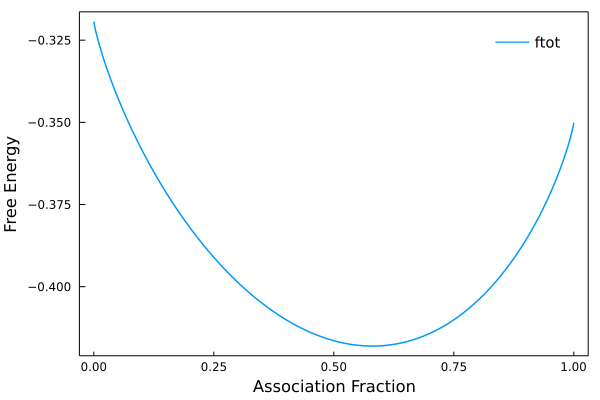

In [6]:
assocvector = LinRange{Float64}(nextfloat(0.0),prevfloat(1.0),1000)
ftot = similar(assocvector)
for (i,assoctest) in enumerate(assocvector)
    ftot[i] = ftranslational(phi, assoctest, SinglePolyionModel)
    ftot[i] += fcombinatorial(phi, assoctest, SinglePolyionModel)
    ftot[i] += fbinding(phi, assoctest, SinglePolyionModel)
    ftot[i] += fchi(phi, SinglePolyionModel)
    ftot[i] += felectrostatic(phi, assoctest, SinglePolyionModel)
end
fmin,minind = findmin(ftot)
assocmin = assocvector[minind]
println("minimum energy of $fmin at alpha = $assocmin")
fig = plot(xlabel = "Association Fraction", ylabel = "Free Energy")
plot!(fig,assocvector,ftot,label="ftot")

Compute and plot association fraction as a function of polymer concentration with no added salt

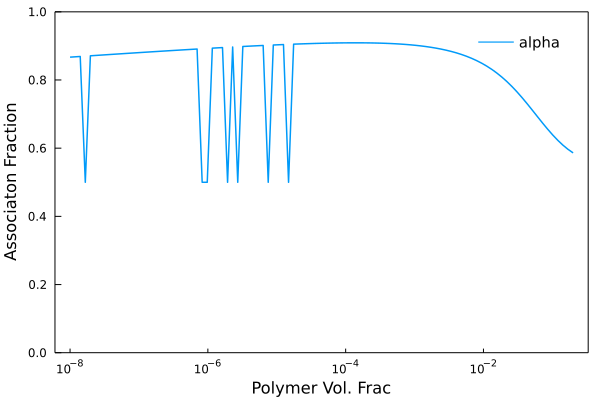

In [7]:
phivector = 10 .^ LinRange{Float64}(-8,log10(0.2),100)
alpha = similar(phivector)
for (i,phitest) in enumerate(phivector)
    alpha[i] = varsolve(neutralbulk([phitest,0.00],SinglePolyionModel),SinglePolyionModel, show_trace=false, extended_trace=true)[1]
end
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Associaton Fraction", xscale = :log10)
plot!(fig,phivector,alpha,label="alpha",ylim = (0,1))

Repeat above computation for various values of the chain length, $N$

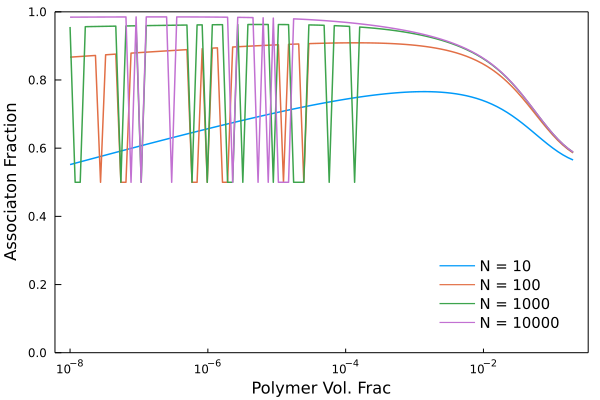

In [8]:
Nvector = 10 .^ (1:4)
alpha = Array{Float64}(undef,length(phivector),length(Nvector))
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Associaton Fraction", xscale = :log10,ylim = (0,1), legend = :bottomright)
for (j,Ntest) in enumerate(Nvector)
    for (i,phitest) in enumerate(phivector)
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)
        alpha[i,j] = varsolve(neutralbulk([phitest,0.0],testmodel),testmodel)[1]
    end
    plot!(fig,phivector,alpha[:,j],label="N = $Ntest")
end
display(fig)

Estimate the contribution of each of the energy terms to the overall free energy

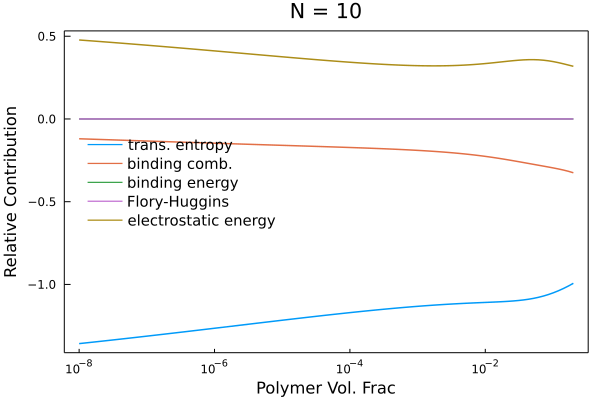

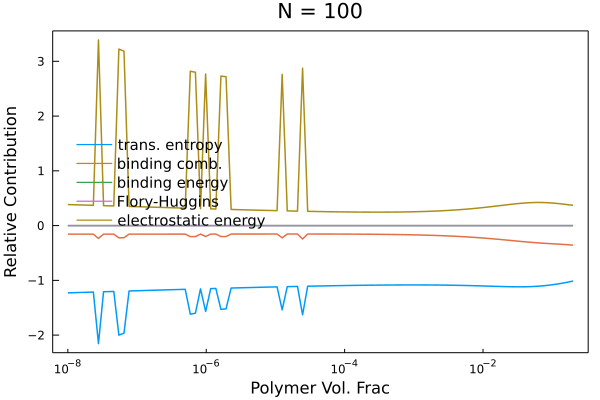

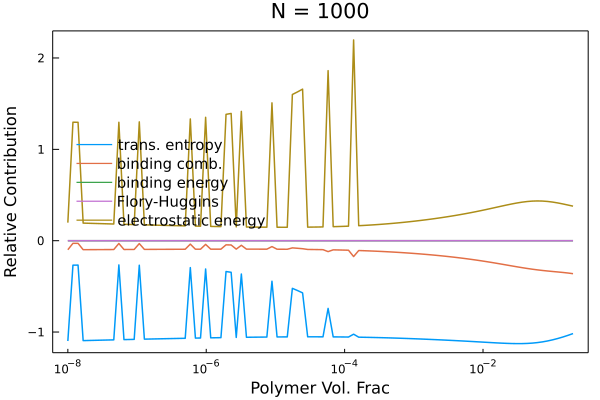

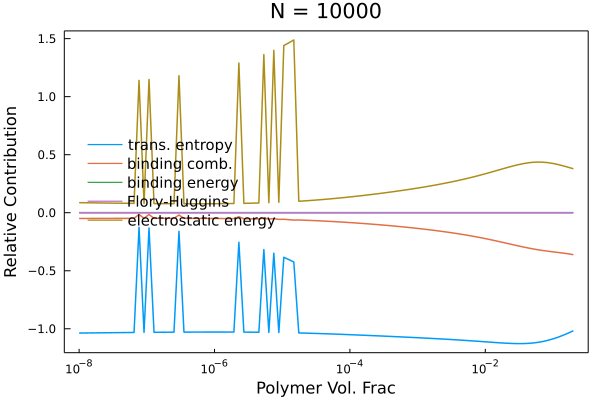

In [9]:
ftrans_frac = Array{Float64}(undef,length(phivector),length(Nvector))
fcomb_frac = similar(ftrans_frac)
fbind_frac = similar(ftrans_frac)
fel_frac = similar(ftrans_frac)
fchi_frac = similar(ftrans_frac)
for (j,Ntest) in enumerate(Nvector)
    fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Relative Contribution", xscale = :log10, legend = :left, title = "N = $Ntest")
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)
        phi = neutralbulk([phitest,nextfloat(0.0)],testmodel)
        ftrans = ftranslational(phi, assoc, testmodel)
        fcomb = fcombinatorial(phi, assoc, testmodel)
        fbind = fbinding(phi, assoc, testmodel)
        fch = fchi(phi, testmodel)
        fel = felectrostatic(phi, assoc, testmodel)
        ftot = ftrans + fcomb + fbind + fch + fel
        ftrans_frac[i,j], fcomb_frac[i,j], fbind_frac[i,j], fel_frac[i,j], fchi_frac[i,j] = (ftrans, fcomb, fbind, fel, fch) ./ abs(ftot)
    end
    plot!(fig,phivector,ftrans_frac[:,j],label="trans. entropy")
    plot!(fig,phivector,fcomb_frac[:,j],label="binding comb.")
    plot!(fig,phivector,fbind_frac[:,j],label="binding energy")
    plot!(fig,phivector,fchi_frac[:,j],label="Flory-Huggins")
    plot!(fig,phivector,fel_frac[:,j],label="electrostatic energy")
    display(fig)
end

Compute the electrostatic exchange chemical potentials at equilibrium

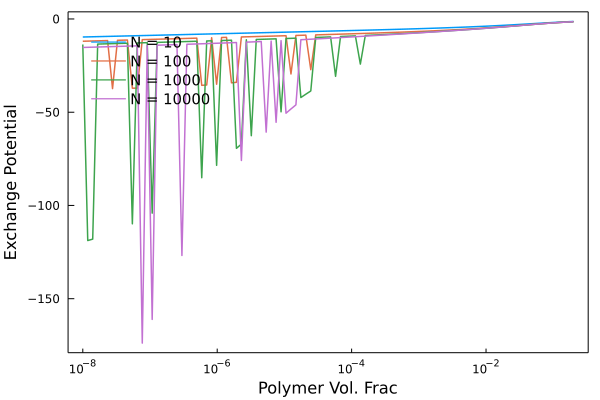

In [10]:
muel = Array{Float64}(undef,length(phivector),length(Nvector))
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Exchange Potential", xscale = :log10, legend = :topleft)
for (j,Ntest) in enumerate(Nvector)
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)    
        muel[i,j] = muel_association(neutralbulk([phitest,0.0],testmodel), assoc, testmodel)
    end
    plot!(fig,phivector,muel[:,j],label="N = $Ntest")
end
display(fig)

Create and test function to compute exchange potential for translational entropy

In [11]:
function mutrans_association(phi, vars, model::SinglePolyion;
    z::Float64 = 1.0)
    phiA, phiP, phiM = phi
    wA, wP, wM = model.omega

    # Derived parameters
    alpha = vars[1]
    sigA = 1 - alpha
    phiPF = phiP - alpha*phiA*wP/(wA*z)

    # Compute entropic exchange potential
    pot = -(1+log(phiPF))/z

    return pot
end

mutrans_association (generic function with 1 method)

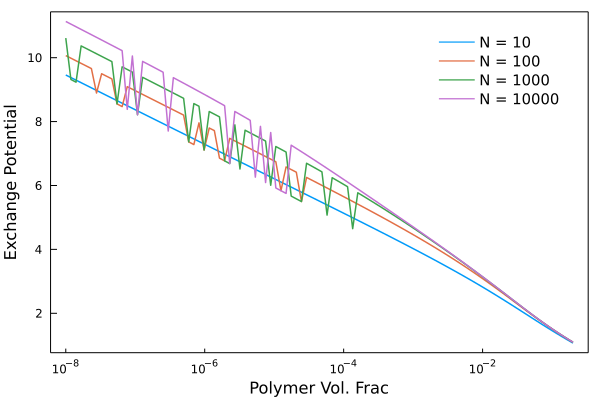

In [12]:
mutrans = Array{Float64}(undef,length(phivector),length(Nvector))
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Exchange Potential", xscale = :log10, legend = :topright)
for (j,Ntest) in enumerate(Nvector)
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)    
        mutrans[i,j] = mutrans_association(neutralbulk([phitest,0.0],testmodel), assoc, testmodel, z = 2.0)
    end
    plot!(fig,phivector,mutrans[:,j],label="N = $Ntest")
end
display(fig)

Create and test function to compute exchange potential for binding combinatorics

In [13]:
function mucomb_association(phi, vars, model::SinglePolyion)
    phiA, phiP, phiM = phi

    # Derived parameters
    alpha = vars[1]
    sigA = 1 - alpha

    # Compute entropic exchange potential
    pot = log(alpha) - log(sigA)

    return pot
end

mucomb_association (generic function with 1 method)

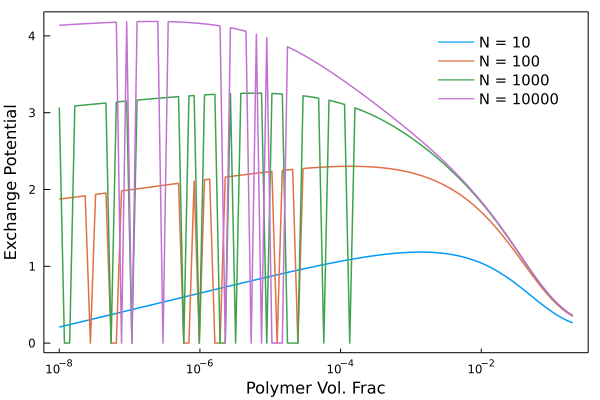

In [14]:
mucomb = Array{Float64}(undef,length(phivector),length(Nvector))
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Exchange Potential", xscale = :log10)
for (j,Ntest) in enumerate(Nvector)
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)    
        mucomb[i,j] = mucomb_association(neutralbulk([phitest,0.0],testmodel), assoc, testmodel)
    end
    plot!(fig,phivector,mucomb[:,j],label="N = $Ntest")
end
display(fig)

Create and test function to compute exchange potential for local binding energy

In [15]:
function mubind_association(phi, vars, model::SinglePolyion;
    z::Float64 = 1.0)
    phiA, phiP, phiM = phi
    dg = model.dg

    # Compute entropic exchange potential
    pot = dg/z

    return pot
end

mubind_association (generic function with 1 method)

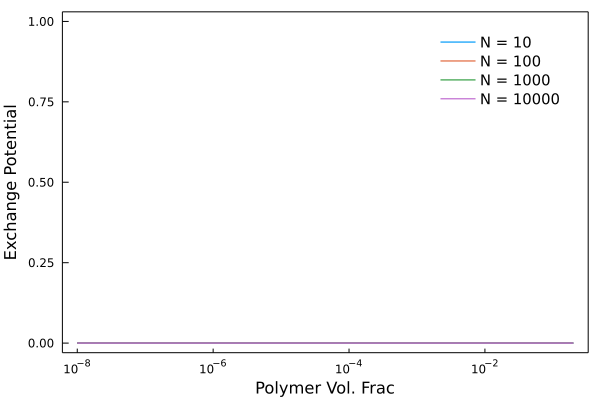

In [16]:
mubind = Array{Float64}(undef,length(phivector),length(Nvector))
fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Exchange Potential", xscale = :log10, legend = :topright)
for (j,Ntest) in enumerate(Nvector)
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)    
        mubind[i,j] = mubind_association(neutralbulk([phitest,0.0],testmodel), assoc, testmodel, z = 2.0)
    end
    plot!(fig,phivector,mubind[:,j],label="N = $Ntest")
end
display(fig)

Estimate the contribution of each of the exchange potentials to the association fraction

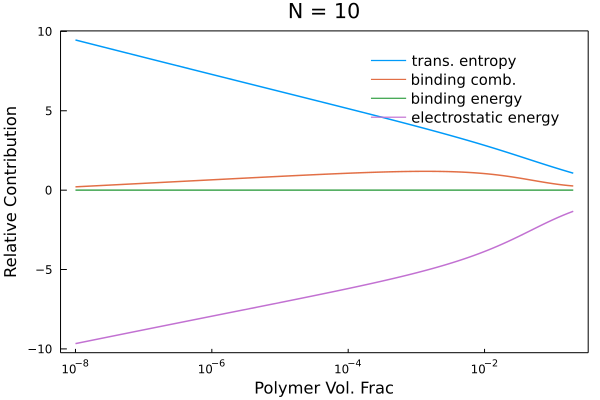

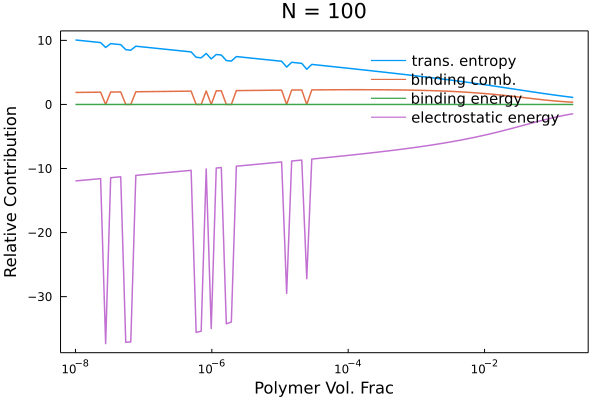

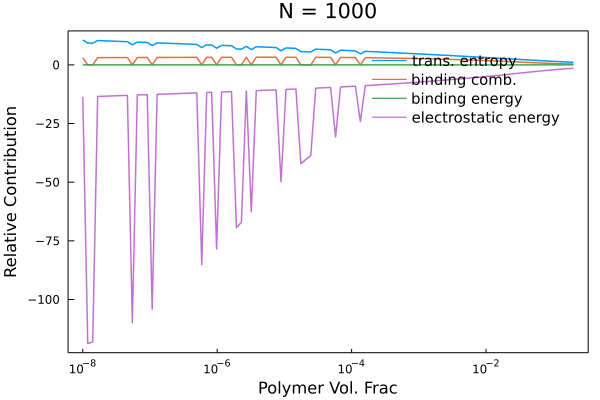

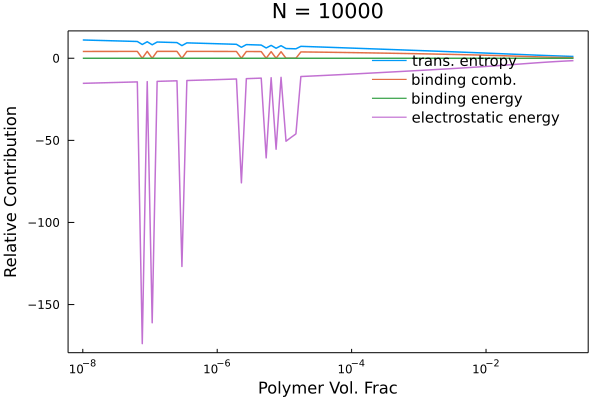

In [17]:
mutrans = (Array{Float64}(undef,length(phivector),length(Nvector)))
mucomb = similar(mutrans)
mubind = similar(mutrans)
muel = similar(mutrans)
for (j,Ntest) in enumerate(Nvector)
    fig = plot(xlabel = "Polymer Vol. Frac", ylabel = "Relative Contribution", xscale = :log10, legend = :best, title = "N = $Ntest")
    for (i,phitest) in enumerate(phivector)
        assoc = alpha[i,j]
        testmodel = SinglePolyion(structure = GaussianCoil, dp = Ntest)
        phi = neutralbulk([phitest,nextfloat(0.0)],testmodel)
        mutrans[i,j] = mutrans_association(phi, assoc, testmodel, z = 2.0)
        mucomb[i,j] = mucomb_association(phi, assoc, testmodel)
        mubind[i,j] = mubind_association(phi, assoc, testmodel, z = 2.0)
        muel[i,j] = muel_association(phi, assoc, testmodel)
    end
    plot!(fig,phivector,mutrans[:,j],label="trans. entropy")
    plot!(fig,phivector,mucomb[:,j],label="binding comb.")
    plot!(fig,phivector,mubind[:,j],label="binding energy")
    plot!(fig,phivector,muel[:,j],label="electrostatic energy")
    display(fig)
end